In [1]:
from tqdm.notebook import tqdm

import jax
import optax

from dart import dataset, VirtualRadar, fields, DART

In [2]:
sensor = VirtualRadar.from_config("data/sim_96.json", n=256, k=128)

gt = dataset.gt_map("data/map.mat")
ds = dataset.dart("data/traj.mat", "data/sim_96.npz", sensor, pre_shuffle=True)
ds = ds.shuffle(100000, reshuffle_each_iteration=True)

In [5]:
optimizer = optax.adamw(optax.exponential_decay(
    0.01, 500, 0.01, transition_begin=100, end_value=0.001))

def sigma():
    return fields.SimpleGrid(
        (100, 100, 100), lower=gt.lower, resolution=gt.resolution * 2) 
dart = DART(sensor, optimizer, sigma)
state = dart.init(jax.random.PRNGKey(42), ds.batch(2))

In [6]:
state = dart.fit(jax.random.PRNGKey(42), ds.batch(2048), state, epochs=1, tqdm=tqdm)

Epoch 0:   0%|          | 0/441 [00:00<?, ?batch/s]

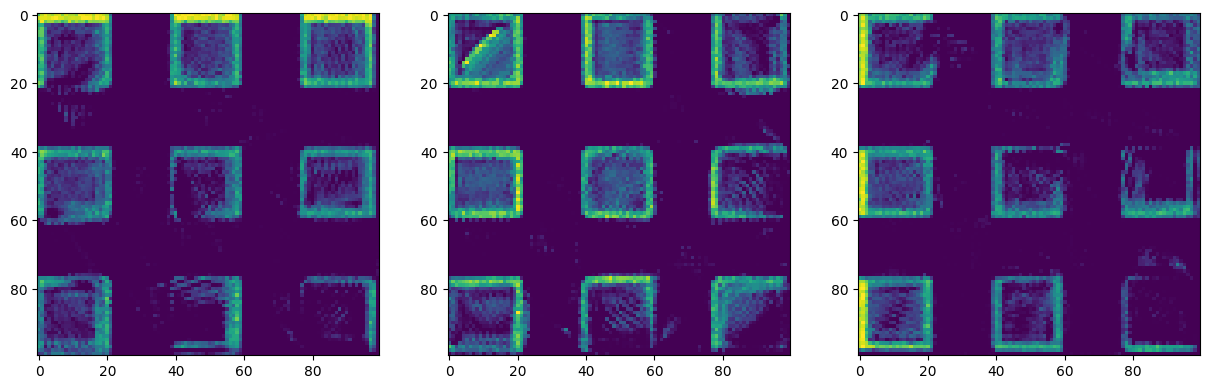

In [7]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([10, 50, 90], axs):
    ax.imshow(state.params['simple_grid']['grid'][:, :, layer])